<a href="https://colab.research.google.com/github/Hkd225/sentiment-analysis-MLBB/blob/main/Sentiment_Analysis_of_MLBB_Indonesian_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install google-play-scraper


from google_play_scraper import app, reviews, Sort, reviews_all

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
from google_play_scraper import app, reviews_all, Sort,reviews


scrapreview, continuation_token = reviews(
    'com.mobile.legends',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT,
    count=40000
)

In [3]:
import csv

with open('ulasan_aplikasi.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Review'])  # Menulis header kolom
    for review in scrapreview:
        writer.writerow([review['content']])

In [4]:

app_reviews_df = pd.DataFrame(scrapreview)


clean_df = app_reviews_df.dropna(subset=['content'])

# Menghapus duplikat berdasarkan isi ulasan
clean_df = clean_df.drop_duplicates(subset=['content'])

#Menyimpan hasil akhir ke CSV baru
clean_df.to_csv('ulasan_bersih.csv', index=False)

# 6. Final check
print(f"Jumlah ulasan awal: {len(app_reviews_df)}")
print(f"Jumlah ulasan setelah dibersihkan: {clean_df.shape[0]}")
review = clean_df.copy()

Jumlah ulasan awal: 40000
Jumlah ulasan setelah dibersihkan: 39990


In [5]:
import pandas as pd
import re
import string
import csv
import requests
from io import StringIO
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Pastikan NLTK terunduh
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


#INISIALISASI GLOBAL (Stemmer, Stopwords, Lexicon)

print("1. Memuat kamus Sastrawi & Stopwords... (Tunggu sebentar)")
factory = StemmerFactory()
stemmer = factory.create_stemmer()

listStopwords = set(stopwords.words('indonesian'))
listStopwords_eng = set(stopwords.words('english'))
listStopwords.update(listStopwords_eng)

# Mengamankan kata negasi
kata_negasi = {"tidak", "bukan", "belum", "jangan", "enggan"}
listStopwords = listStopwords - kata_negasi

# Typo ccustom_stop sudah diperbaiki menjadi custom_stop
custom_stop = ['iya','yaa','nya','na','sih','ku',"di","ya","gaa","loh","kah",
               "woi","woii","woy", "aja", "banget", "gw", "gua", "lu", "kalo",
               "dah", "doang", "kek", "cuman", "biar", "bikin", "gimana",
               "mulu", "udah", "pa", "pas", "tau", "kayak"]
listStopwords.update(custom_stop)

print("2. Mengunduh Kamus Lexicon dari GitHub...")
lexicon_positive = dict()
response_pos = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response_pos.status_code == 200:
    reader = csv.reader(StringIO(response_pos.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
response_neg = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response_neg.status_code == 200:
    reader = csv.reader(StringIO(response_neg.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1. Memuat kamus Sastrawi & Stopwords... (Tunggu sebentar)
2. Mengunduh Kamus Lexicon dari GitHub...


In [6]:
slangwords = {# 1. ABREVIASI KATA GANTI, KONJUNGSI, DAN KOMUNIKASI UMUM (General Mechanics)
    "gw": "saya", "gua": "saya", "gwa": "saya", "gue": "saya", "aq": "saya", "aku": "saya",
    "lu": "kamu", "lo": "kamu", "loe": "kamu", "elu": "kamu", "kau": "kamu",
    "yg": "yang", "dgn": "dengan", "klo": "kalau", "kalo": "kalau", "klu": "kalau",
    "tp": "tetapi", "tpi": "tetapi", "tapi": "tetapi",
    "udh": "sudah", "udah": "sudah", "sdh": "sudah", "blum": "belum", "blm": "belum",
    "bisa": "bisa", "bs": "bisa", "bnyk": "banyak", "byk": "banyak", "gb": "ukuran",
    "ga": "tidak", "gk": "tidak", "gak": "tidak", "ngga": "tidak", "nggak": "tidak", "g": "tidak",
    "aj": "saja", "aja": "saja", "ajaa": "saja", "ajah": "saja", "ajagame": "saja game", "ajaitu": "saja itu",
    "jga": "juga", "jg": "juga", "jgn": "jangan", "jangan": "jangan",
    "bgt": "banget", "bgtt": "banget", "bngt": "banget", "banged": "banget", "bangettt": "banget",
    "ajaknp": "saja kenapa", "ajantar": "saja nanti", "ajatapi": "saja tetapi", "ajatolong": "saja tolong",
    "aint": "tidak", "gameaja": "game saja", "gamenya": "game", "gameny": "game",
    "bener": "benar", "Bener": "benar", "wkwk": "tertawa", "wk": "tertawa",
    "bgs": "bagus", "jlk": "jelek", "mntp": "mantap", "kcewa": "kecewa", "kikir": "pelit",
    "suck": "menyebalkan", "good": "bagus", "top": "terbaik",
    "anniv": "ulang tahun", "anniversary": "ulang tahun",
    "thank": "terima kasih", "thx": "terima kasih", "thanks": "terima kasih",
    "skip": "lewati", "hp": "handphone", "gift": "hadiah", "astaga": "ya tuhan",
    "maaf": "maaf", "sry": "maaf", "tolong": "tolong", "bantu": "tolong", "help": "tolong",
    "terus": "lanjutkan", "ngapain": "sedang apa","ngaco" : "asal", "match" : "pertandingan", "ls" : "kalah berturut-turut",
    # 2. IDENTIFIKASI SPASIAL, PETA, DAN PEMBAGIAN PERAN (Spatial & Roles Designations)
    "atas": "jalur atas", "toplane": "jalur atas",
    "bawah": "jalur bawah", "bot": "jalur bawah", "botlane": "jalur bawah",
    "tengah": "jalur tengah", "mid": "jalur tengah", "midlane": "jalur tengah",
    "gold": "jalur emas", "goldlane": "jalur emas",
    "exp": "jalur pengalaman", "explane": "jalur pengalaman", "offlane": "jalur tunggal",
    "jungle": "hutan", "jungler": "pemain hutan", "hyper": "penyerang utama", "core": "penyerang utama",
    "roam": "penjelajah", "roamer": "penjelajah", "roaming": "menjelajah",
    "tank": "pelindung", "mage": "penyihir", "mm": "penembak", "marksman": "penembak",
    "ass": "pembunuh", "assassin": "pembunuh", "fighter": "petarung",
    "spp": "pendukung", "support": "pendukung", "carry": "pembawa kemenangan",

    # 3. TERMINOLOGI GAMEPLAY, STATUS, MEKANIK DAN METAFORA (Gameplay & Idioms)
    "cd": "waktu tunggu", "cooldown": "waktu tunggu", "cdr": "pengurangan waktu tunggu",
    "afk": "keluar permainan", "dc": "putus koneksi",
    "skill": "kemampuan", "ulti": "jurus utama", "ultimate": "jurus utama",
    "retri": "mantra hutan", "retribution": "mantra hutan",
    "flicker": "mantra teleportasi", "purify": "mantra pembersih", "spell": "mantra",
    "buff": "peningkatan status", "nerf": "penurunan status", "revamp": "pembaruan karakter",
    "meta": "strategi populer", "makro": "strategi peta", "mekanik": "keterampilan jari",
    "ks": "curi pembunuhan", "nyampah": "curi pembunuhan", "mukil": "rakus pembunuhan",
    "feed": "banyak mati", "feeder": "banyak mati", "atm": "banyak mati",
    "tb": "tahan badan", "cover": "lindungi tim", "bantai": "habisi",
    "push": "hancurkan menara", "end": "akhiri permainan", "backdoor": "serang diam-diam",
    "lord": "raja monster", "turtle": "kura-kura monster", "minion": "prajurit kecil",
    "base": "markas", "fountain": "tempat lahir", "tower": "menara pertahanan",
    "gank": "keroyok", "ganking": "keroyok", "war": "pertarungan tim", "teamfight": "pertarungan tim",
    "poke": "serangan kecil", "harass": "ganggu musuh", "taunt": "ejekan",
    "bait": "pancingan", "zoning": "batasi area", "freeze": "tahan prajurit",
    "lifesteal": "hisap darah", "spellvamp": "hisap darah sihir",
    "dps": "kerusakan per detik", "burst": "kerusakan instan", "damage": "kerusakan", "dmg": "kerusakan",
    "kda": "rasio bunuh mati", "wr": "persentase kemenangan", "winrate": "persentase kemenangan",
    "buta map": "tidak melihat peta", "butamap": "tidak melihat peta",
    "indomaret": "mantra hutan gagal", "retri indomaret": "mantra hutan gagal",
    "jago ii": "sangat ahli", "jago jago": "sangat ahli", "jago": "ahli",
    "turu": "tidur", "bobo": "tidur", "bo2": "tidur", "musik": "waktu balas dendam",

    # 4. KELENGKAPAN PERALATAN DAN ITEM (Equipment Abbreviations)
    "bod": "pedang keputusasaan", "blade of despair": "pedang keputusasaan",
    "gds": "tombak naga besar", "great dragon spear": "tombak naga besar",
    "hs": "serangan pemburu", "hunter strike": "serangan pemburu",
    "bla": "kapak haus darah", "bloodlust axe": "kapak haus darah",
    "won": "angin alam", "wind of nature": "angin alam",
    "rgm": "meteor emas mawar", "rose gold meteor": "meteor emas mawar",
    "def": "pertahanan", "build": "susunan peralatan", "gears": "peralatan", "item": "peralatan",

    # 5. STRATIFIKASI KOMUNITAS, RANKING, EKONOMI DAN SISTEM (Community & Ranking Systems)
    "mabar": "main bersama", "party": "main bersama", "coop": "main bersama",
    "badak": "pemain peringkat rendah", "epic": "peringkat epik", "legend": "peringkat legenda",
    "mythic": "peringkat mitos", "glory": "peringkat kejayaan", "immortal": "peringkat abadi",
    "joki": "jasa pemain pengganti", "pilot": "jasa pemain pengganti",
    "winstreak": "menang beruntun", "ws": "menang beruntun",
    "losestreak": "kalah beruntun", "ls": "kalah beruntun",
    "dark system": "sistem tidak adil", "montoon": "pengembang game", "moonton": "pengembang game",
    "dev": "pengembang", "developer": "pengembang", "update": "perbarui", "rate": "persentase",
    "character star": "karakter bintang", "quest": "misi", "mission": "misi",


    # 6. GACHA, KEBERUNTUNGAN & GENERAL ANIME/RPG TERM (Genshin Impact Overlap)
    "ampas": "jelek", "bapuk": "jelek", "wangi": "bagus", "wangy": "bagus",
    "rateoff": "kalah", "rateon": "menang", "pity": "jaminan", "spook": "nyasar",
    "pull": "tarik", "gacha": "undi", "rng": "acak", "kuli": "capek", "b5": "karakter",
    "char": "karakter", "chara": "karakter", "weap": "senjata",
    "arte": "artefak", "arti": "artefak", "resin": "energi",
    "primo": "koin", "primogem": "koin", "primogems": "koin",
    "mhy": "pengembang", "mihoyo": "pengembang", "hoyo": "pengembang", "hoyoverse": "pengembang",
    "f2p": "gratisan", "whale": "sultan", "sepuh": "ahli", "puh": "ahli", "newbie": "pemula",
    "artefact": "barang", "artifact": "barang", "artefacts": "barang", "artefak": "barang", "artifak": "barang",

    # 7. TEKNIS & PERFORMA KOMPUTER (Technical Performance)
    "fc": "eror", "lag": "lambat", "ngelag": "lambat", "delay": "lambat", "patah": "lambat",
    "ping": "koneksi", "berat": "lambat", "bug": "eror", "stuck": "nyangkut",
    "batre": "baterai", "panas": "panas", "logout": "keluar", "silit": "jelek",

    # 8. TOKSISITAS, AGresi VERBAL, DAN SLANG KASAR (Hostile Lexicon & Insults)
    "tolol": "bodoh", "goblok": "bodoh", "bego": "bodoh", "bloon": "bodoh", "idiot": "bodoh",
    "asu": "anjing", "anjing": "anjing", "ajg": "anjing", "njir": "anjing", "anjir": "anjing",
    "lee": "alat kelamin laki-laki", "babi": "babi", "sampah": "tidak berguna",
    "beban": "menyusahkan tim", "bocil": "anak kecil", "toxic": "pemain beracun",
    "nub": "pemula", "noob": "pemula", "cupu": "lemah",# 1. Singkatan & Kata Gaul (Slang)
    "bgs": "bagus",
    "goblok": "bodoh",
    "banget": "sekali",
    "bikin": "membuat",
    "nagih": "ketagihan",
    "tiap": "setiap",
    "oke": "bagus",
    "lumayan": "cukup",
    "hp": "ponsel",
    "buat": "untuk",
    "kesel": "kesal",
    "hoki": "beruntung",
    "bareng": "bersama",
    "lama-lama": "seiring waktu",
    "terus": "selalu",

    # 2. Istilah Bahasa Inggris Umum
    "random": "acak",
    "smooth": "mulus",
    "player": "pemain",
    "toxic": "berperilaku buruk",
    "report": "lapor",
    "ping": "jaringan",
    "wifi": "internet",
    "worth it": "sepadan",
    "login": "masuk",
    "cheater": "pemain curang",
    "maintenance": "perbaikan",
    "season": "musim",
    "reward": "hadiah",
    "stuck": "terjebak",
    "delay": "tertunda",
    "solo": "sendiri",

    # 3. Istilah Spesifik Game (Domain-Specific)
    "gamenya": "permainannya",
    "lag": "macet",
    "matchmaking": "pencarian pertandingan",
    "match": "pertandingan",
    "force close": "keluar paksa",
    "rank": "peringkat",
    "gameplay": "cara bermain",
    "patch": "pembaruan",
    "overpowered": "sangat kuat",
    "error": "bermasalah",
    "responsif": "cepat tanggap",
    "top up": "isi ulang",
    "gacha": "undian",
    "kuota": "data internet",
    "bug": "kecacatan sistem",
    "push rank": "naik peringkat",
    "diamond": "mata uang",
    "reconnect": "menyambung ulang"
}


def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', str(text)) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9_]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf (dan angka yang sudah hilang)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

def casefoldingText(text):
    return text.lower()

def fix_slangwords(text):
    return ' '.join([slangwords.get(word, word) for word in text.split()])

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(tokens):
    return [word for word in tokens if word not in listStopwords]

def stemmingText(tokens):
    return [stemmer.stem(word) for word in tokens]

def toSentence(list_words):
    return ' '.join(list_words)

# Fungsi sentimen yang sudah kebal dari KeyError 0
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    # Menggunakan parameter 'text', BUKAN 'review'
    if isinstance(text, str):
        words = text.split()
    elif isinstance(text, list):
        words = text
    else:
        try:
            words = list(text)
        except:
            return 0, 'neutral'

    for i, word in enumerate(words):
        is_negated = False
        if i > 0 and str(words[i-1]) in ["tidak", "bukan", "belum", "jangan"]:
            is_negated = True

        word_str = str(word)

        if word_str in lexicon_positive:
            weight = lexicon_positive[word_str]
            score += (-weight if is_negated else weight)

        if word_str in lexicon_negative:
            weight = abs(lexicon_negative[word_str])
            score -= (-weight if is_negated else weight)

    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [7]:
# EKSEKUSI PIPELINE PADA DATAFRAME


print("\n3. Mulai Preprocessing Teks... (Tunggu beberapa saat)")
review = clean_df.copy() # Menggunakan variabel review agar aman

review['text_clean'] = review['content'].apply(cleaningText)
review['text_casefolding'] = review['text_clean'].apply(casefoldingText)
review['text_slangwords'] = review['text_casefolding'].apply(fix_slangwords)
review['text_tokenizing'] = review['text_slangwords'].apply(tokenizingText)
review['text_stopword'] = review['text_tokenizing'].apply(filteringText)

print("4. Mulai proses Stemming... (Ini memakan waktu paling lama)")
review['text_stemmed'] = review['text_stopword'].apply(stemmingText)
review['text_akhir'] = review['text_stemmed'].apply(toSentence)

print("5. Menghitung Skor Sentimen...")
# Menerapkan sentimen pada text_stemmed
results = review['text_stemmed'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
review['polarity_score'] = results[0]
review['polarity'] = results[1]

print("\nDistribusi Sentimen Akhir:")
print(review['polarity'].value_counts())


3. Mulai Preprocessing Teks... (Tunggu beberapa saat)
4. Mulai proses Stemming... (Ini memakan waktu paling lama)
5. Menghitung Skor Sentimen...

Distribusi Sentimen Akhir:
polarity
negative    30506
positive     8079
neutral      1405
Name: count, dtype: int64



6. Menyiapkan Visualisasi WordCloud...


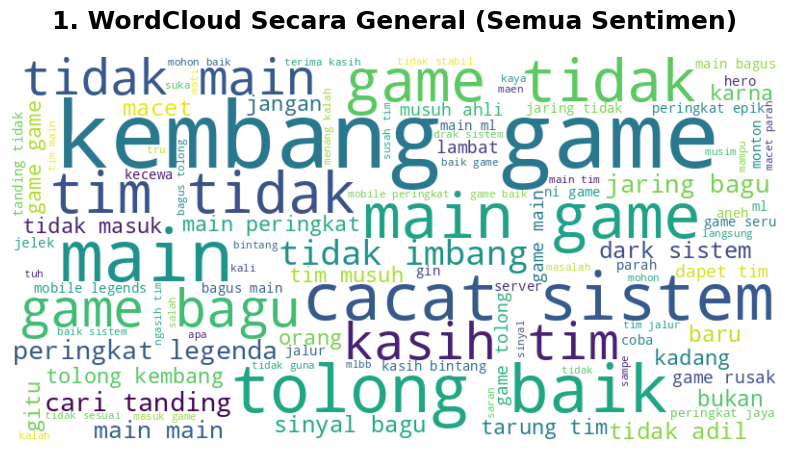

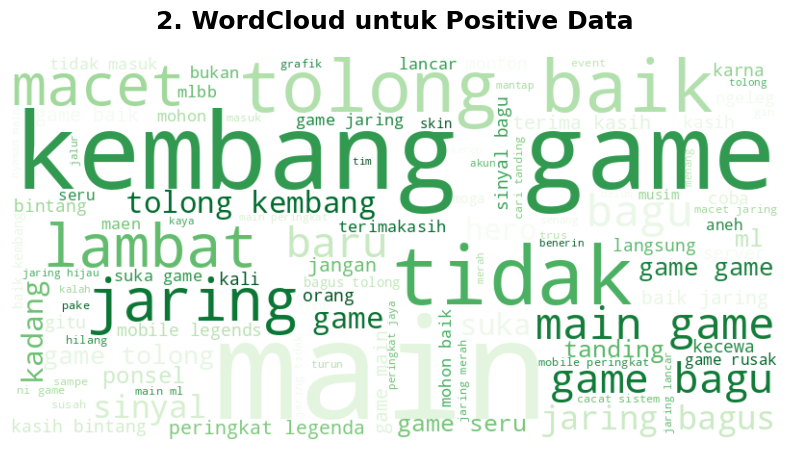

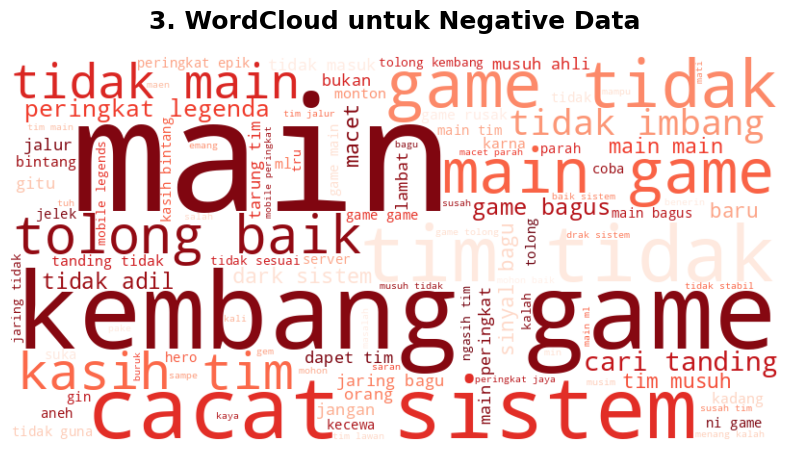

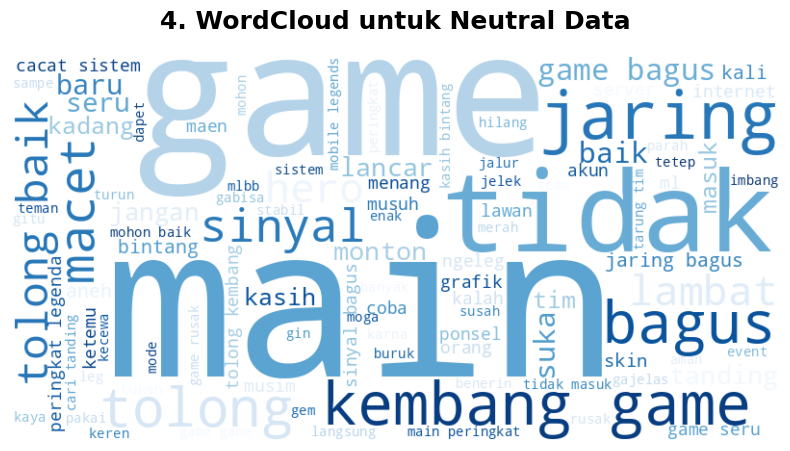

In [8]:

# VISUALISASI WORDCLOUD (DENGAN TAMBAHAN NETRAL)

print("\n6. Menyiapkan Visualisasi WordCloud...")

# Mengelompokkan teks berdasarkan sentimen
text_general = ' '.join(review['text_akhir'].astype(str).dropna())
text_positive = ' '.join(review[review['polarity'] == 'positive']['text_akhir'].astype(str).dropna())
text_negative = ' '.join(review[review['polarity'] == 'negative']['text_akhir'].astype(str).dropna())

# ---> TAMBAHAN: Mengelompokkan teks untuk sentimen Netral
text_neutral = ' '.join(review[review['polarity'] == 'neutral']['text_akhir'].astype(str).dropna())


def plot_wordcloud(text, title, colormap):
    if not text.strip():
        print(f"Peringatan: Tidak ada data kata untuk {title}")
        return
    wordcloud = WordCloud(
        width=800, height=400, background_color='white',
        colormap=colormap, max_words=100, contour_width=3, contour_color='steelblue'
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=18, pad=20, fontweight='bold')
    plt.axis('off')
    plt.show()

# Memanggil fungsi plot untuk ke-4 kategori
plot_wordcloud(text_general, '1. WordCloud Secara General (Semua Sentimen)', 'viridis')
plot_wordcloud(text_positive, '2. WordCloud untuk Positive Data', 'Greens')
plot_wordcloud(text_negative, '3. WordCloud untuk Negative Data', 'Reds')

# ---> TAMBAHAN: Memanggil plot WordCloud Netral (Menggunakan tema warna Biru/Blues)
plot_wordcloud(text_neutral, '4. WordCloud untuk Neutral Data', 'Blues')

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd


print("1. Memisahkan fitur (X) dan target label (y)...")


X = review['text_akhir'].astype(str).fillna('')
y = review['polarity']


print("2. Melakukan Data Splitting (80% Train, 20% Test)...")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"   -> Jumlah Data Latih (Training) : {X_train.shape[0]} baris")
print(f"   -> Jumlah Data Uji (Testing)    : {X_test.shape[0]} baris")


print("\n3. Memulai Ekstraksi Fitur dengan TF-IDF...")


tfidf = TfidfVectorizer()


X_train_tfidf = tfidf.fit_transform(X_train)

X_test_tfidf = tfidf.transform(X_test)

print("   -> Ekstraksi fitur selesai!")
print(f"   -> Dimensi Matriks Data Latih : {X_train_tfidf.shape} (Baris, Jumlah Fitur Kata)")
print(f"   -> Dimensi Matriks Data Uji   : {X_test_tfidf.shape} (Baris, Jumlah Fitur Kata)")


fitur_kata = tfidf.get_feature_names_out()
print("\nContoh 10 kata yang dijadikan fitur oleh TF-IDF:")
print(fitur_kata[100:110])

1. Memisahkan fitur (X) dan target label (y)...
2. Melakukan Data Splitting (80% Train, 20% Test)...
   -> Jumlah Data Latih (Training) : 31992 baris
   -> Jumlah Data Uji (Testing)    : 7998 baris

3. Memulai Ekstraksi Fitur dengan TF-IDF...
   -> Ekstraksi fitur selesai!
   -> Dimensi Matriks Data Latih : (31992, 31772) (Baris, Jumlah Fitur Kata)
   -> Dimensi Matriks Data Uji   : (7998, 31772) (Baris, Jumlah Fitur Kata)

Contoh 10 kata yang dijadikan fitur oleh TF-IDF:
['active' 'actually' 'acu' 'acuh' 'acuin' 'acung' 'acunt' 'ad' 'ada'
 'adaa']


In [10]:
!pip install gensim tensorflow

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec

# --- Library Deep Learning (LSTM) ---
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import EarlyStopping

# Menyiapkan Data X dan y
X = review['text_akhir'].astype(str).fillna('')
y = review['polarity']

print("Mulai Menjalankan 3 Skema Eksperimen (Machine Learning vs Deep Learning)...\n")
print("="*50)



# SKEMA 1: Sequence Embedding + RNN/GRU + Split 70:30
#=================================================


print("⏳ Menjalankan SKEMA 1 (Sequence | RNN-GRU | Split 70:30)...")

# 1. Membagi Data (Diperbaiki menjadi test_size=0.2)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Label Encoding untuk Neural Network
encoder1 = LabelEncoder()
y_train_encoded1 = encoder1.fit_transform(y_train1)
y_test_encoded1 = encoder1.transform(y_test1)

# 3. Tokenisasi dan Padding (Syarat wajib untuk RNN/GRU)
max_len1 = 50
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(X_train1)

X_train_seq1 = tokenizer1.texts_to_sequences(X_train1)
X_test_seq1 = tokenizer1.texts_to_sequences(X_test1)

X_train_pad1 = pad_sequences(X_train_seq1, maxlen=max_len1, padding='post')
X_test_pad1 = pad_sequences(X_test_seq1, maxlen=max_len1, padding='post')

vocab_size1 = len(tokenizer1.word_index) + 1

# 4. Membangun Arsitektur RNN varian GRU
model_gru = Sequential()

# Embedding biasa, membiarkan GRU belajar makna kata dari nol (tanpa Word2Vec)
model_gru.add(Embedding(input_dim=vocab_size1, output_dim=100))

# Menggunakan GRU (Saudara LSTM yang lebih ringan dan cepat)
model_gru.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))

# Layer rahasia kesuksesan Anda sebelumnya (Dropout + Dense ReLU)
model_gru.add(Dropout(0.5))
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dropout(0.2))

# Output layer 3 kelas
model_gru.add(Dense(3, activation='softmax'))

model_gru.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 5. Melatih Model (Kita gunakan 15 Epochs agar tidak terlalu lama menunggunya)
print("   [Info] Melatih model RNN/GRU, silakan tunggu...")
model_gru.fit(X_train_pad1, y_train_encoded1, epochs=15, batch_size=32, verbose=1)

# 6. Evaluasi Skema 1
y_pred1_prob = model_gru.predict(X_test_pad1, verbose=0)
y_pred1_classes = np.argmax(y_pred1_prob, axis=1)

akurasi_skema1 = accuracy_score(y_test_encoded1, y_pred1_classes)
print(f"✅ Skema 1 Selesai dengan Akurasi: {akurasi_skema1 * 100:.2f}%\n")


# SKEMA 2: Word2Vec + LSTM + Split 70:30 (DEEP LEARNING)
#=================================================


print("⏳ Menjalankan SKEMA 2 (Word2Vec | LSTM | Split 80:20)...")
print("   [Info] Membangun arsitektur Neural Network, ini akan memakan waktu sedikit lebih lama...")

# 1. Label Encoding (LSTM butuh label berupa angka 0, 1, 2)
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train1)
y_test_encoded = encoder.transform(y_test1)

# 2. Tokenisasi Keras & Padding (Menyamakan panjang kalimat)
max_len = 50 # Asumsi panjang maksimal 1 ulasan adalah 50 kata
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train1)

X_train_seq = tokenizer.texts_to_sequences(X_train1)
X_test_seq = tokenizer.texts_to_sequences(X_test1)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# 3. Melatih Gensim Word2Vec
X_train_tok = [str(text).split() for text in X_train1]
w2v_model = Word2Vec(sentences=X_train_tok, vector_size=100, window=5, min_count=3, workers=4)
hentikan_otomatis = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4. Membuat Embedding Matrix untuk disuntikkan ke LSTM
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# 5. Membangun Model LSTM
model_lstm = Sequential()
# Memasukkan bobot Word2Vec ke dalam Embedding Layer
model_lstm.add(Embedding(input_dim=vocab_size,
                         output_dim=100,
                         weights=[embedding_matrix],
                         trainable=True)) # False agar bobot W2V asli tidak rusak
model_lstm.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(3, activation='softmax')) # 3 = Jumlah kelas sentimen

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 6. Melatih Model LSTM
# Epochs = jumlah perulangan belajar. Gunakan 5 agar tidak terlalu lama untuk eksperimen.
model_lstm.fit(X_train_pad, y_train_encoded,
               epochs=100,
               batch_size=64,
               validation_data=(X_test_pad, y_test_encoded),
               callbacks=[hentikan_otomatis],
               verbose=1)

# 7. Evaluasi LSTM
y_pred2_prob = model_lstm.predict(X_test_pad, verbose=1)
y_pred2_classes = np.argmax(y_pred2_prob, axis=1) # Mengambil kelas dengan probabilitas tertinggi

akurasi_skema2 = accuracy_score(y_test_encoded, y_pred2_classes)
print(f"✅ Skema 2 Selesai!\n")


# SKEMA 3: TF-IDF + SVM + Split 70:30
#=================================================

print("⏳ Menjalankan SKEMA 3 (TF-IDF | SVM | Split 70:30)...")
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.3, random_state=42)

tfidf3 = TfidfVectorizer(min_df=3)
X_train_tfidf3 = tfidf3.fit_transform(X_train3)
X_test_tfidf3 = tfidf3.transform(X_test3)

svm_tfidf = SVC(kernel='linear', random_state=42)
svm_tfidf.fit(X_train_tfidf3, y_train3)
y_pred3 = svm_tfidf.predict(X_test_tfidf3)
akurasi_skema3 = accuracy_score(y_test3, y_pred3)
print(f"✅ Skema 3 Selesai!\n")

print("="*50)

# RINGKASAN HASIL
# =================================================
print("🏆 KESIMPULAN HASIL EKSPERIMEN 🏆")
print("-" * 50)
print(f"Skema 1 (model RNN/GRU [70:30]) : {akurasi_skema1 * 100:.2f}%")
print(f"Skema 2 (Word2Vec + LSTM [70:30])      : {akurasi_skema2 * 100:.2f}%")
print(f"Skema 3 (TF-IDF + SVM [70:30])         : {akurasi_skema3 * 100:.2f}%")
print("-" * 50)

# Mencari skema terbaik otomatis
hasil = {"Skema 1": akurasi_skema1, "Skema 2": akurasi_skema2, "Skema 3": akurasi_skema3}
skema_terbaik = max(hasil, key=hasil.get)
print(f"🚀 Skema paling optimal untuk dataset Anda adalah: {skema_terbaik}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 60.9 MB/s eta 0:00:00
Mulai Menjalankan 3 Skema Eksperimen (Machine Learning vs Deep Learning)...

⏳ Menjalankan SKEMA 1 (Sequence | RNN-GRU | Split 70:30)...
   [Info] Melatih model RNN/GRU, silakan tunggu...
Epoch 1/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 74s 79ms/step - accuracy: 0.7576 - loss: 0.6957
Epoch 2/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.8675 - loss: 0.3795
Epoch 3/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 69s 78ms/step - accuracy: 0.9293 - loss: 0.2044
Epoch 4/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9470 - loss: 0.1475
Epoch 5/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 81s 79ms/step - accuracy: 0.9602 - loss: 0.1164
Epoch 6/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9649 - loss: 0.0981
Epoch 7/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 74s 85ms/step - accuracy: 0.9692 - loss: 0.0864
Epoch 8/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 78s 80ms/step - accuracy: 0.9698 - loss: 0.0778
Epoch 9/15
875/875 ━━━━━━━━━━

In [11]:
import joblib

# ==============================================================================
# MENYIMPAN MODEL DAN OBJEK PENDUKUNG
# ==============================================================================
print("\n" + "="*50)
print("💾 MENYIMPAN MODEL DAN OBJEK KE DALAM FILE...")

# ---------------------------------------------------------
# 1. Simpan Skema 1 (GRU Model & Objek Pendukung)
# ---------------------------------------------------------
# Menyimpan Model GRU
model_gru.save('model_skema1_gru.keras')
# Menyimpan Tokenizer dan LabelEncoder Skema 1
joblib.dump(tokenizer1, 'tokenizer_skema1.joblib')
joblib.dump(encoder1, 'label_encoder_skema1.joblib')
print("✅ Skema 1 (GRU) beserta Tokenizer & Encoder berhasil disimpan.")

# ---------------------------------------------------------
# 2. Simpan Skema 2 (LSTM Model, Word2Vec, & Objek Pendukung)
# ---------------------------------------------------------
# Menyimpan Model LSTM
model_lstm.save('model_skema2_lstm.keras')
# Menyimpan model Word2Vec (opsional, jika ingin melihat vektor kata di masa depan)
w2v_model.save('word2vec_skema2.model')
# Menyimpan Tokenizer dan LabelEncoder Skema 2 (sama dengan skema 1, tapi disimpan agar rapi)
joblib.dump(tokenizer, 'tokenizer_skema2.joblib')
joblib.dump(encoder, 'label_encoder_skema2.joblib')
print("✅ Skema 2 (LSTM & Word2Vec) beserta Tokenizer & Encoder berhasil disimpan.")

# ---------------------------------------------------------
# 3. Simpan Skema 3 (SVM Model & TF-IDF Vectorizer)
# ---------------------------------------------------------
# Menyimpan Model SVM
joblib.dump(svm_tfidf, 'model_skema3_svm.joblib')
# Menyimpan TF-IDF Vectorizer (SANGAT PENTING untuk mengubah teks baru menjadi angka nanti)
joblib.dump(tfidf3, 'tfidf_vectorizer_skema3.joblib')
print("✅ Skema 3 (SVM) beserta TF-IDF Vectorizer berhasil disimpan.")

print("="*50)
print("🎉 SEMUA PROSES SELESAI! Model siap digunakan untuk klasifikasi data baru.")


💾 MENYIMPAN MODEL DAN OBJEK KE DALAM FILE...
✅ Skema 1 (GRU) beserta Tokenizer & Encoder berhasil disimpan.
✅ Skema 2 (LSTM & Word2Vec) beserta Tokenizer & Encoder berhasil disimpan.
✅ Skema 3 (SVM) beserta TF-IDF Vectorizer berhasil disimpan.
🎉 SEMUA PROSES SELESAI! Model siap digunakan untuk klasifikasi data baru.


In [12]:
# Jalankan di cell Colab
!pip freeze > requirements.txt

print("File requirements.txt berhasil dibuat dari seluruh environment Colab!")

File requirements.txt berhasil dibuat dari seluruh environment Colab!


In [14]:
# ==============================================================================
# 🧪 TES PREDIKSI KALIMAT BARU (DENGAN PREPROCESSING)
# ==============================================================================
print("\n" + "="*50)
print("🔍 UJI COBA MODEL DENGAN ULASAN BARU")
print("="*50)

# 1. Masukkan kalimat mentah yang ingin diuji
ulasan_baru_mentah = [
    "Gamenya seru banget bikin nagih tiap malam main",
"Grafiknya bagus dan hero-heronya keren",
"Sering lag padahal jaringan lancar",
"Matchmaking-nya kadang tidak adil",
"Skin mahal tapi kualitasnya oke",
"Eventnya banyak dan hadiahnya lumayan",
"Sering force close setelah update terbaru",
"Ukuran gamenya terlalu besar di HP",
"Rank susah naik karena tim random",
"Gameplay makin seru sejak patch kemarin",
"Hero baru overpowered banget",
"Server sering error saat jam ramai",
"Kontrolnya smooth dan responsif",
"Banyak player toxic bikin emosi",
"Mode brawl seru buat santai",
"Sistem report kurang efektif",
"Efek skill terlihat keren dan detail",
"Ping sering merah padahal wifi stabil",
"Battle pass cukup worth it",
"Top up mahal banget",
"Musiknya bikin semangat main",
"Loading awal terlalu lama",
"Hadiah login harian lumayan membantu",
"Gacha kurang hoki bikin kesel",
"Komunitasnya ramai dan aktif",
"Sering ketemu cheater di rank tinggi",
"Animasi hero halus dan realistis",
"Tutorialnya mudah dipahami pemula",
"Update terlalu sering bikin boros kuota",
"Skin legend tampilannya mewah banget",
"Voice line heronya keren",
"Bug masih banyak setelah maintenance",
"Push rank bareng teman jadi lebih seru",
"Sistem emblem cukup membingungkan",
"Match sering tidak seimbang",
"Map terlihat detail dan menarik",
"Sering stuck di loading screen",
"Reward season cukup memuaskan",
"Hero lama kurang diperhatikan",
"Gameplay terasa repetitif lama-lama",
"Kolaborasi eventnya keren banget",
"Harga diamond tidak ramah di kantong",
"Rank system bikin ketagihan",
"Kadang tiba-tiba reconnect sendiri",
"Fitur baru cukup membantu pemain baru",
"Sinyal bagus tapi tetap delay",
"Desain karakter unik dan beragam",
"Server luar lebih stabil dari lokal",
"Main solo sering kalah terus",
"Secara keseluruhan masih seru dimainkan"
]

# 2. Proses pembersihan kalimat agar sama dengan data latih
ulasan_baru_bersih = []
print("Membersihkan teks ulasan baru...")
for teks in ulasan_baru_mentah:
    t = cleaningText(teks)
    t = casefoldingText(t)
    t = fix_slangwords(t)
    t = tokenizingText(t)
    t = filteringText(t)
    t = stemmingText(t)
    t = toSentence(t)
    ulasan_baru_bersih.append(t)

print("Teks Siap Prediksi:", ulasan_baru_bersih)

# --- TES SKEMA 1 (GRU) ---
print("\n[ Hasil Prediksi Skema 1 (Sequence + GRU) ]")
# Gunakan teks yang SUDAH BERSIH
seq1 = tokenizer1.texts_to_sequences(ulasan_baru_bersih)
pad1 = pad_sequences(seq1, maxlen=max_len1, padding='post')
pred_prob1 = model_gru.predict(pad1, verbose=0)
pred_class1 = np.argmax(pred_prob1, axis=1)
hasil_teks1 = encoder1.inverse_transform(pred_class1)

for teks_asli, hasil in zip(ulasan_baru_mentah, hasil_teks1):
    print(f"Ulasan: '{teks_asli}'\nPrediksi: {hasil}\n")


# --- TES SKEMA 2 (LSTM + Word2Vec) ---
print("-" * 50)
print("\n[ Hasil Prediksi Skema 2 (LSTM + Word2Vec) ]")
# Gunakan teks yang SUDAH BERSIH
seq2 = tokenizer.texts_to_sequences(ulasan_baru_bersih)
pad2 = pad_sequences(seq2, maxlen=max_len, padding='post')
pred_prob2 = model_lstm.predict(pad2, verbose=0)
pred_class2 = np.argmax(pred_prob2, axis=1)
hasil_teks2 = encoder.inverse_transform(pred_class2)

for teks_asli, hasil in zip(ulasan_baru_mentah, hasil_teks2):
    print(f"Ulasan: '{teks_asli}'\nPrediksi: {hasil}\n")


# --- TES SKEMA 3 (SVM + TF-IDF) ---
print("-" * 50)
print("\n[ Hasil Prediksi Skema 3 (SVM + TF-IDF) ]")
# Gunakan teks yang SUDAH BERSIH
vektor_tfidf3 = tfidf3.transform(ulasan_baru_bersih)
pred_class3 = svm_tfidf.predict(vektor_tfidf3)

for teks_asli, hasil in zip(ulasan_baru_mentah, pred_class3):
    print(f"Ulasan: '{teks_asli}'\nPrediksi: {hasil}\n")

print("="*50)


🔍 UJI COBA MODEL DENGAN ULASAN BARU
Membersihkan teks ulasan baru...
Teks Siap Prediksi: ['main seru tagih malam main', 'grafik bagus heroheronya keren', 'macet jaring lancar', 'matchmakingnya kadang tidak adil', 'skin mahal kualitas bagus', 'eventnya hadiah', 'force close baru baru', 'ukur main ponsel', 'peringkat susah tim acak', 'main seru baru kemarin', 'hero kuat', 'server masalah jam ramai', 'kontrol mulus cepat tanggap', 'main perilaku buruk emosi', 'mode brawl seru santai', 'sistem lapor efektif', 'efek mampu keren detail', 'jaring merah internet stabil', 'battle pass worth', 'baik mahal', 'musik semangat main', 'loading', 'hadiah masuk hari bantu', 'undi untung kesal', 'komunitas ramai aktif', 'ketemu main curang peringkat', 'animasi hero halus realistis', 'tutorial mudah paham mula', 'baru boros data internet', 'skin peringkat legenda tampil mewah', 'voice line hero keren', 'cacat sistem baik', 'hancur menara peringkat teman seru', 'sistem emblem bingung', 'tanding tidak imb